In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import math
from sklearn.neighbors import KernelDensity
from scipy.stats import norm, loggamma

In [3]:
# data import

us_accidents = pd.read_csv(filepath_or_buffer='/content/drive/MyDrive/US_Accidents.csv', sep=',', usecols=['Temperature(F)','Wind_Chill(F)','Humidity(%)'])
us_accidents

,Temperature(F),Wind_Chill(F),Humidity(%)
0,36.9,NaN,91.0
1,37.9,NaN,100.0
2,36.0,33.3,100.0
3,35.1,31.0,96.0
4,36.0,33.3,89.0
...,...,...,...
4232536,86.0,86.0,40.0
4232537,70.0,70.0,73.0
4232538,73.0,73.0,64.0
4232539,71.0,71.0,81.0


In [4]:
# Renaming columns

us_accidents = us_accidents.rename(columns={'Humidity(%)':'Humidity','Temperature(F)':'Temperature','Wind_Chill(F)':'Wind_Chill'})

In [ ]:
# Calcluating overall time of the accident - NOT USED

import datetime

us_accidents['Total_Time'] = [datetime.datetime.strptime(us_accidents['End_Time'].iloc[i], '%Y-%m-%d %H:%M:%S')-datetime.datetime.strptime(us_accidents['Start_Time'].iloc[i], '%Y-%m-%d %H:%M:%S') for i in range(len(us_accidents.index))]
us_accidents['Total_Time'] = [us_accidents['Total_Time'].iloc[i].total_seconds()/3600 for i in range(len(us_accidents.index))]

In [ ]:
# Interactive heatmap for general visualization for our dataset

import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=us_accidents.State.value_counts().index,  # Spatial coordinates
    z = us_accidents.State.value_counts().values.astype(float),  # Data to be color-coded
    locationmode = 'USA-states',  # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "accidents",
))

fig.update_layout(
    title_text = 'The number of accidents in USA',
    geo_scope='usa',  # limite map scope to USA
)

fig.show()

**FUNCTIONS**

In [5]:
#Kernel Density Estimation

def kde(feature):
    
    column = feature

    model = KernelDensity(bandwidth=2, kernel='gaussian')
    column = column.values.reshape((len(column), 1))
    model.fit(column)

    min, max = feature.min(), feature.max()
    values = np.asarray([value for value in range(int(min), int(max))])
    values = values.reshape((len(values), 1))
    probabilities = model.score_samples(values)
    probabilities = np.exp(probabilities)
    
    sns.set_theme()
    sns.histplot(feature, kde=False, bins=int(5 * math.log10(len(feature.index))), stat='density')
    plt.plot(values[:], probabilities, color='red')

In [6]:
# Cutting ends

def cut_ends(feature):

  q_1, q_3 = np.percentile(feature, [25, 75])
  dfce = q_3 - q_1
  bottom_border, top_border = q_1 - 1.5*dfce, q_3 + 1.5*dfce
  feature = feature[feature > bottom_border]
  feature = feature[feature < top_border]

  return feature

In [7]:
# Calculating order statistics

def order_stats(param, name):

  min = param.min()
  max = param.max()
  mean = param.mean()
  var = param.var()
  std = param.std()
  median = None
  
  print('Min = ' + str(min))
  print('Max = ' + str(max))
  print('Average = ' + str(round(mean,2)))
  print('Variance = ' + str(round(var,2)))
  print('Standart deviation = ' + str(round(std,2)))
  
  if type(param) == type(np.array([])):
    median = np.median(param)
  else:
    median = param.median()

  print('Median = ' + str(round(median,2)))


  def mad(df):
    
    sigma = 1.2
    k = scipy.stats.lognorm.ppf(3/4., s=sigma)
    
    return k * np.median(np.fabs(df - median))


  mad = mad(param)
  print('MAD = ' + str(round(mad,2)))

  truncated_mean = scipy.stats.trim_mean(param, proportiontocut=0.1)
  print('Trancated Mean = ' + str(round(truncated_mean,2)))

  sns.set_theme()
  sns.set(rc={'figure.figsize':(10,6)})
  ax = sns.boxplot(x=param)
  ax.set(xlabel=name)

In [8]:
# Estimation Parameters, using Least-Squares and Maximum Likelyhood

def param_estimation(feature, distribution, start_point):

  def least_squares(x_arr, y_arr, pdf):
    return np.sum((pdf(x_arr) - y_arr) ** 2)

  def distr_func(x_arr, pdf):
    return pdf(x_arr)

  n_bins = int(5 * math.log10(len(feature.index)))
  hist, borders = np.histogram(feature, bins=n_bins, density=True)
  borders += (borders[0] - borders[1]) / 2
  borders = borders[1:]

  opt_func = lambda args: least_squares(borders, hist, distribution(*args).pdf)
  ls_params = scipy.optimize.minimize(opt_func, start_point, method="nelder-mead", options={'disp': True, 'maxiter': 2000})

  ml_params = distribution.fit(feature)

  print('LS parameters: ' + str(ls_params.x))
  print('ML parameters: ' + str(ml_params))
  
  distr_val = lambda args: distr_func(borders, distribution(*args).pdf)

  sns.set_theme()
  sns.histplot(feature, kde=False, bins=n_bins, stat='density')
  plt.plot(borders, distr_val(list(ls_params.x)), color='red', label='Least Squares')
  plt.plot(borders, distr_val(list(ml_params)), color='green', label='Maximum Likelyhood')
  plt.legend()

  return ml_params

In [9]:
# QQ-biplot

def qq_plot(feature, distribution):

  percs = np.linspace(0, 100, 100)
  x = np.linspace(np.min(feature), np.max(feature))
  qn_first = np.percentile(feature, percs)
  qn_norm = distribution.ppf(percs / 100.0, *params)

  plt.figure(figsize=(6, 6))
  plt.scatter(qn_first, qn_norm)
  plt.plot(x, x, color="k", ls="--")
  plt.xlim(0, 100)
  plt.ylim(0, 100)
  plt.xlabel('Empirical distribution')
  plt.ylabel('Theoretical distribution')

  plt.show()

In [10]:
# Statistical tests

def statistical_tests(feature, distr):

  ks = scipy.stats.kstest(feature, distr, params)
  chi2 = scipy.stats.chisquare(feature)
  print(ks)
  print(chi2)

**RESULTS**

**Temperature**

In [11]:
feature = us_accidents.Temperature
feature = feature[feature.notnull()]
feature = cut_ends(feature)

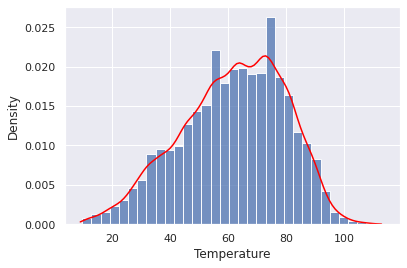

In [12]:
kde(feature)

Min = -89.0
Max = 203.0
Average = 61.48
Variance = 343.21
Standart deviation = 18.53
Median = 63.0
MAD = nan
Trancated Mean = 62.96


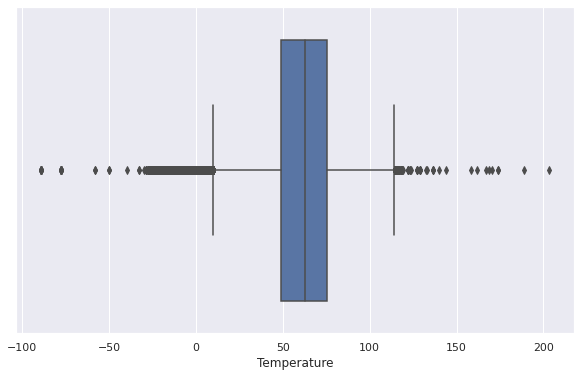

In [13]:
order_stats(us_accidents.Temperature, 'Temperature')

Optimization terminated successfully.
         Current function value: 0.000158
         Iterations: 64
         Function evaluations: 123
LS parameters: [64.2207189  18.76783411]
ML parameters: (61.82850918058874, 17.99322427485785)


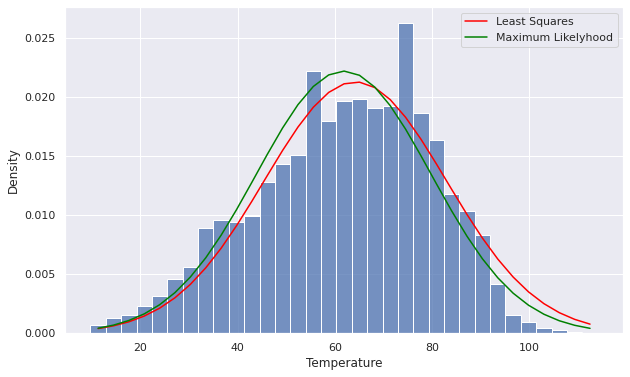

In [14]:
params = param_estimation(feature, norm, [10,10])

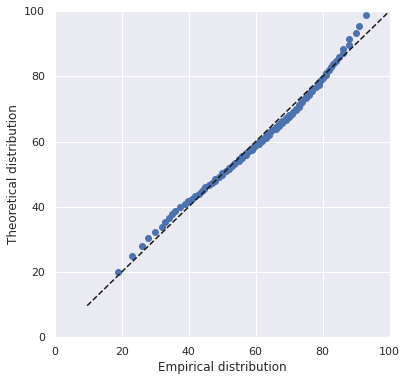

In [15]:
qq_plot(feature, norm)

In [16]:
statistical_tests(feature, 'norm')

KstestResult(statistic=0.0518918953070544, pvalue=0.0)
Power_divergenceResult(statistic=21563792.833352804, pvalue=0.0)


**Humidity**

In [17]:
feature = us_accidents.Humidity
feature = feature[feature.notnull()]
feature = cut_ends(feature)

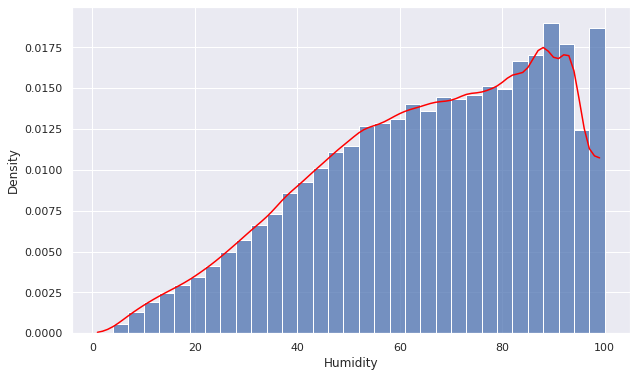

In [18]:
kde(feature)

Min = 1.0
Max = 100.0
Average = 65.67
Variance = 516.35
Standart deviation = 22.72
Median = 68.0
MAD = nan
Trancated Mean = 67.83


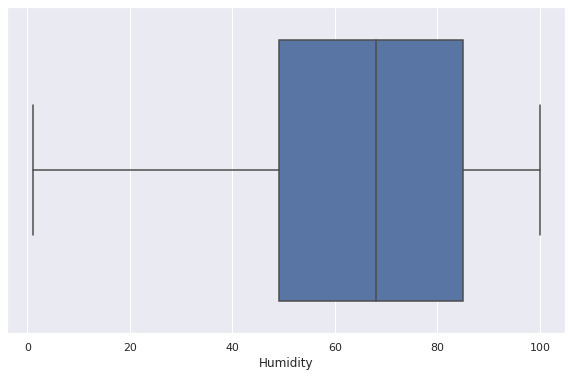

In [19]:
order_stats(us_accidents.Humidity, 'Humidity')

Optimization terminated successfully.
         Current function value: 0.000172
         Iterations: 288
         Function evaluations: 516
LS parameters: [ 0.92856605 82.96119092 21.33961899]
ML parameters: (1.1587309486342015, 72.7446213610323, 20.634991093970783)


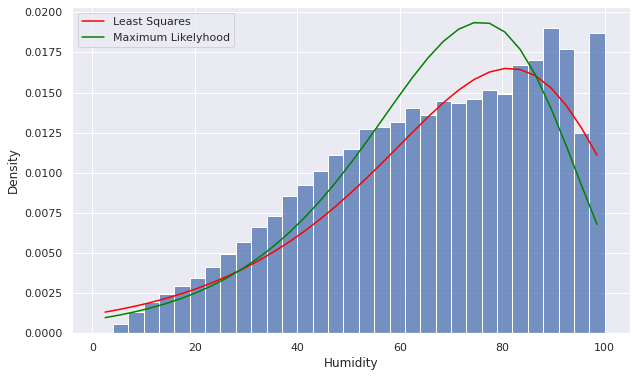

In [20]:
params = param_estimation(feature, loggamma, [10,10,10])

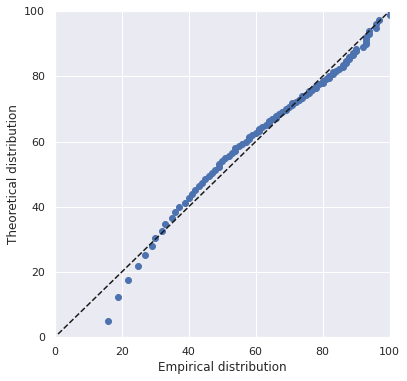

In [21]:
qq_plot(feature, loggamma)

In [22]:
statistical_tests(feature, 'loggamma')

KstestResult(statistic=0.05490048325564989, pvalue=0.0)
Power_divergenceResult(statistic=32527117.658081405, pvalue=0.0)


**Wind Chill**

In [23]:
feature = us_accidents.Wind_Chill
feature = feature[feature.notnull()]
feature = cut_ends(feature)

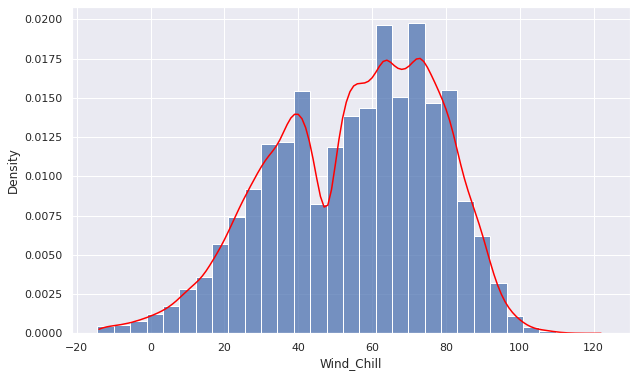

In [24]:
kde(feature)

Min = -89.0
Max = 189.0
Average = 54.89
Variance = 516.36
Standart deviation = 22.72
Median = 58.0
MAD = nan
Trancated Mean = nan


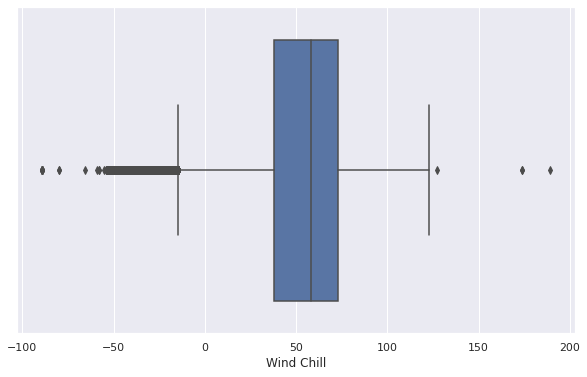

In [25]:
order_stats(us_accidents.Wind_Chill, 'Wind Chill')

Optimization terminated successfully.
         Current function value: 0.000188
         Iterations: 61
         Function evaluations: 116
LS parameters: [58.3947442  24.14518817]
ML parameters: (55.137142908664195, 22.337679163907584)


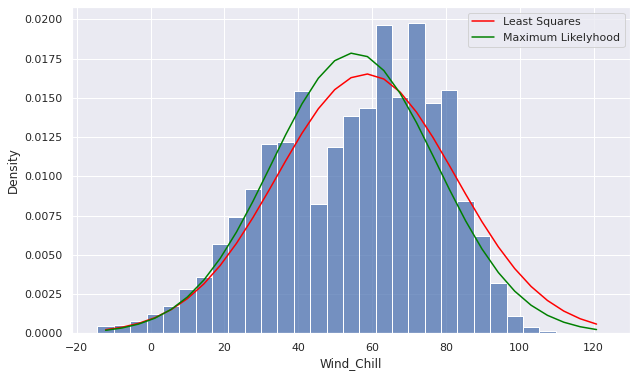

In [26]:
params = param_estimation(feature, norm, [10,10])

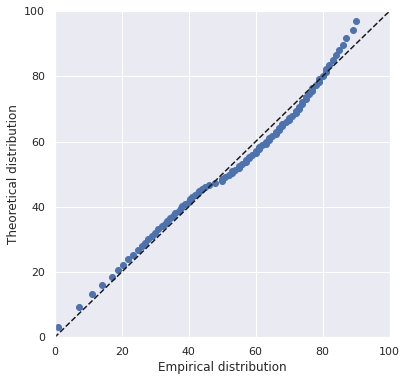

In [27]:
qq_plot(feature, norm)

In [28]:
statistical_tests(feature, 'norm')

KstestResult(statistic=0.06660859043684919, pvalue=0.0)
Power_divergenceResult(statistic=21077823.10440227, pvalue=0.0)
